## Part 1

We begin by import the packages we will need:

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
print('TF version:', tf.__version__)

TF version: 2.1.0


Before moving onto the 2-D Gaussian profile:

In [3]:
X, Y = np.mgrid[-4:4:10**-2, -4:4:10**-2]

xs = tf.constant(X.astype(np.float32))
ys = tf.constant(Y.astype(np.float32))

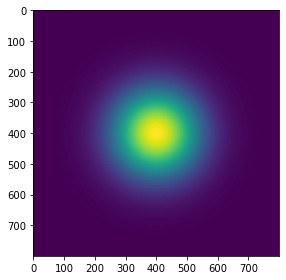

In [4]:
zs_gauss = tf.exp(-(xs**2 + ys**2)/2)

plt.imshow(zs_gauss.numpy())
plt.tight_layout()
plt.show()

And a 2-D periodic profile:

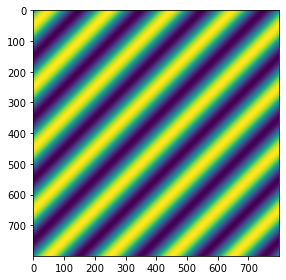

In [5]:
zs_sin = tf.sin(np.pi*(xs+ys))

plt.imshow(zs_sin.numpy())
plt.tight_layout()
plt.show()

And their product:

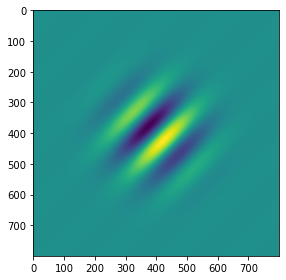

In [6]:
zs_prod = zs_gauss*zs_sin

plt.imshow(zs_prod.numpy())
plt.tight_layout()
plt.show()

## Part 2

In [14]:
def processFractal(a):
    """Display an array of iteration counts as a
    colorful picture of a fractal."""
    a_cyclic = (6.28*a/20.0).reshape(list(a.shape)+[1])
    img = np.concatenate([10+20*np.cos(a_cyclic),
    30+50*np.sin(a_cyclic),
    155-80*np.cos(a_cyclic)], 2)
    img[a==a.max()] = 0
    a = img
    a = np.uint8(np.clip(a, 0, 255))
    return a

In [19]:
def showFractal(xs, zs, ns):
    for i in range(200):
        #Compute the new values of z: z^2 + x
        zs_ = zs*zs + xs
        # Have we diverged with this new value?
        not_diverged = tf.abs(zs_) < 5
        # Update variables to compute
        ns.assign_add(tf.cast(not_diverged, tf.float32))
        zs.assign(zs_)

    fig = plt.figure(figsize=(16,10))

    plt.imshow(processFractal(ns.numpy()))
    plt.tight_layout(pad=0)
    plt.show()

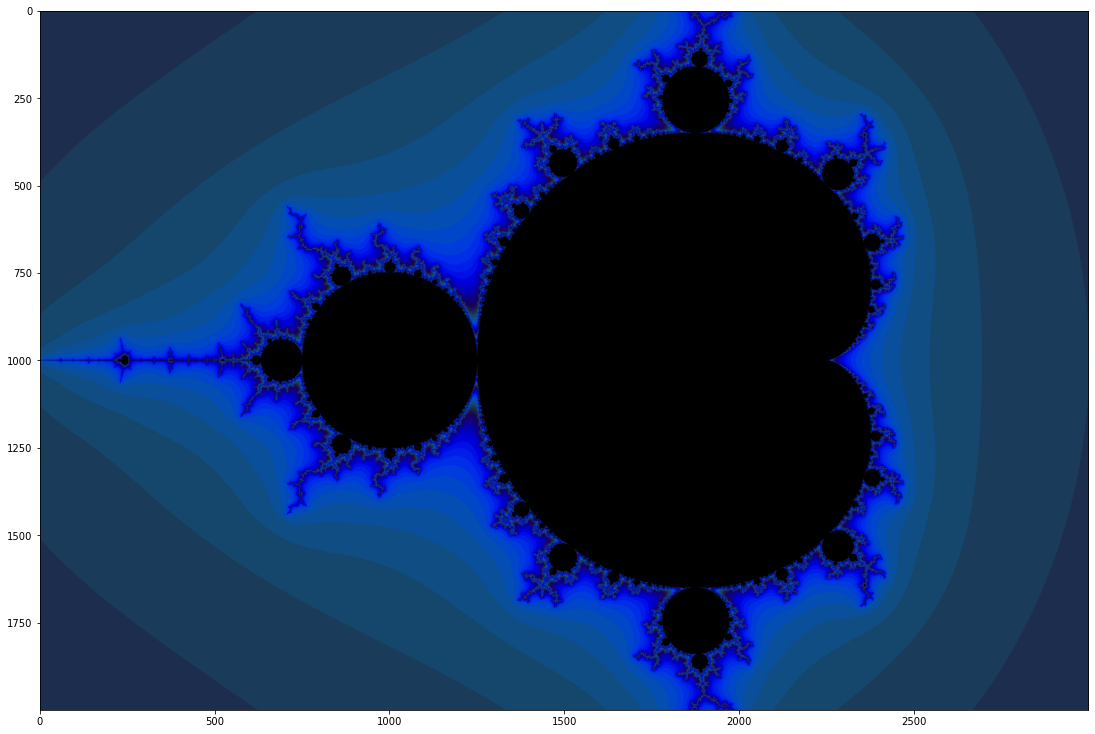

In [20]:
Y, X = np.mgrid[-1:1:10**-3, -2:1:10**-3]
Z = X + 1j*Y

xs = tf.constant(Z.astype(np.complex64))
zs = tf.Variable(xs)
ns = tf.Variable(tf.zeros_like(xs, tf.float32))

showFractal(xs, zs, ns)

We can rerun this with decreased grid spacing ($10^{-3} \rightarrow 4 \times 10^{-4}$) to generate a higher quality image, noting that at a spacing of $10^{-4}$ we need to begin allocating memory more carefully.

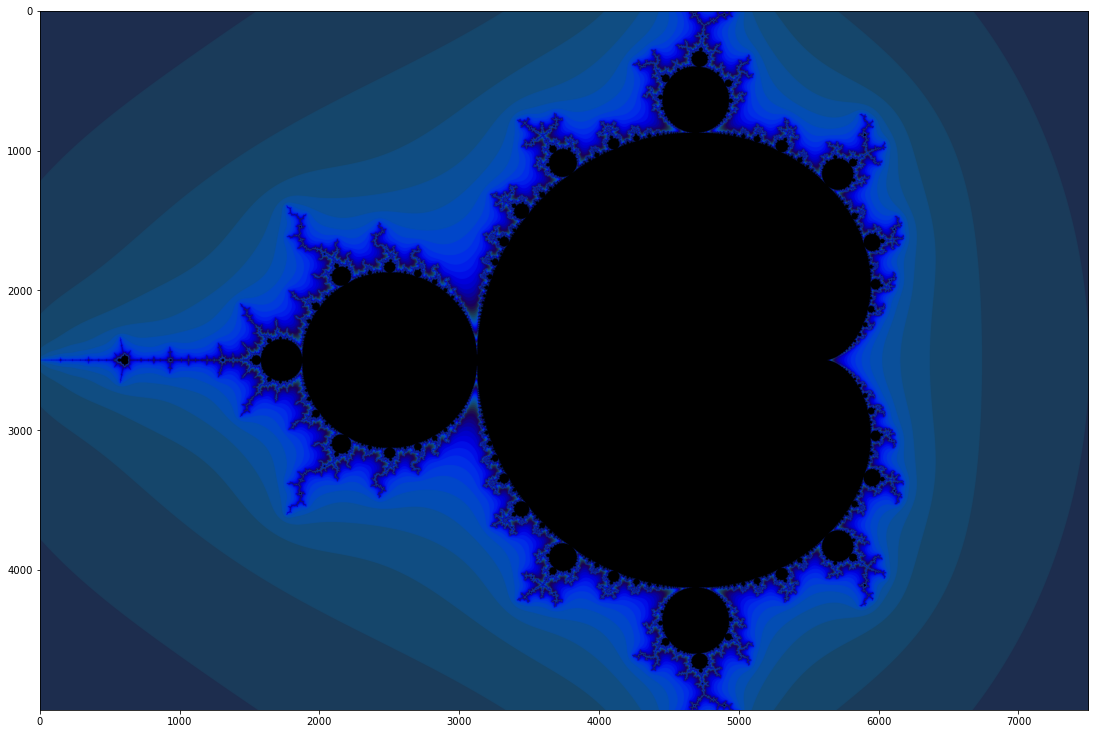

In [28]:
Y, X = np.mgrid[-1:1:4*10**-4, -2:1:4*10**-4]
Z = X + 1j*Y

xs = tf.constant(Z.astype(np.complex64))
zs = tf.Variable(xs)
ns = tf.Variable(tf.zeros_like(xs, tf.float32))

showFractal(xs, zs, ns)